# Frequency/Amplitude Study of the Epileptor 6D

- 6/12/18: from Marisa, I learned how the Epileptor fast system has regions of varying bifurcations, which produce different amplitude/frequency characteristics of the limit cycle (i.e. seizure period). Here, we want to produce simulations and track the trajectory of the fast subsystem variables

In [1]:
import sys
import numpy as np
import os

sys.path.append('../../')
from tvb.simulator.lab import *
import tvbsim

# to run simulation and post processing and data loading
from tvbsim.postprocess.postprocess import PostProcessor
from tvbsim.postprocess.detectonsetoffset import DetectShift
from tvbsim.maintvbexp import MainTVBSim
from tvbsim.io.patient.subject import Subject
from tvbsim.base.constants.config import Config

output_folder = os.path.join(os.path.expanduser("~"), 'Documents', 'figures',
                             'tvbsims')

# to run plotting at the end
from tvbsim.visualize.plotter_sim import PlotterSim
from tvbsim.base.dataobjects.timeseries import TimeseriesDimensions, Timeseries 
from collections import OrderedDict

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# configuration and plotting
config = Config(output_base=output_folder) 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

   INFO  log level set to INFO


In [2]:
def save_processed_data(filename, times, epits, seegts, zts, state_vars):
    print('finished simulating!')
    print(epits.shape)
    print(seegts.shape)
    print(times.shape)
    print(zts.shape)
    print(state_vars.keys())

    # save tseries
    np.savez_compressed(filename, epits=epits, 
                                seegts=seegts,
                                times=times, 
                                zts=zts, 
                                state_vars=state_vars)
    
def process_weights(conn, shuffle=False, patient=None, other_pats=[]):
    if shuffle:
        if other_pats and patient is not None:
            # shuffle across patients
            randpat = MainTVBSim().randshufflepats(other_pats, patient)   
            shuffled_connfile = os.path.join(metadatadir, randpat, 'tvb', 'connectivity.zip')
            if not os.path.exists(shuffled_connfile):
                shuffled_connfile = os.path.join(metadatadir, randpat, 'tvb', 'connectivity.dk.zip')

            conn = connectivity.Connectivity.from_file(shuffled_connfile)
        elif patient is None and not other_pats:
            # shuffle within patients
            randweights = MainTVBSim().randshuffleweights(conn.weights)
            conn.weights = randweights
    return conn

def initialize_tvb_model(loader, ezregions, pzregions, period):
    ###################### INITIALIZE TVB SIMULATOR ##################
    maintvbexp = MainTVBSim(loader.conn, condspeed=np.inf)
    # load the necessary data files to run simulation
    maintvbexp.loadseegxyz(seegfile=loader.seegfile)
    maintvbexp.loadgainmat(gainfile=loader.gainfile)
    maintvbexp.importsurfdata(surf=loader.surf)

    ######### Model (Epileptor) Parameters ##########
    epileptor_params = {
        'r': 0.00037,#/1.5   # Temporal scaling in the third state variable
        'Ks': -10,                 # Permittivity coupling, fast to slow time scale
        'tt': 0.5,                   # time scale of simulation
        'tau': 10,                   # Temporal scaling coefficient in fifth st var
        'x0': -2.45, # x0c value = -2.05
        # 'Iext': iext,
    }
    x0ez=-1.65
    x0pz=-2.0 # x0pz = None
    if ezregions is None:
        x0ez = None
    if pzregions is None:
        x0pz = None
    maintvbexp.loadepileptor(ezregions=ezregions, pzregions=pzregions,
                            x0ez=x0ez, x0pz=x0pz,
                            epileptor_params=epileptor_params)
    allindices = np.hstack((maintvbexp.ezind, maintvbexp.pzind)).astype(int) 
    maintvbexp.ezindices = allindices
    ######### Integrator Parameters ##########
    ntau = 0
    noise_cov = np.array([0.001, 0.001, 0.,\
                              0.0001, 0.0001, 0.])
    # define cov noise for the stochastic heun integrator
    hiss = noise.Additive(nsig=noise_cov, ntau=ntau)
    # hiss = noise.Multiplicative(nsig=noise_cov)
    integrator_params = {
        'dt': 0.05,
#         'noise': hiss,
    }
    maintvbexp.loadintegrator(integrator_params)

    # load couping
    coupling_params = {
        'a': 1.,
    }
    maintvbexp.loadcoupling(**coupling_params)

    # load monitors
    initcond = None
    monitor_params = {
        'period': period,
        'moved': False,
        'initcond': initcond
    }
    maintvbexp.loadmonitors(**monitor_params)
    return maintvbexp

In [3]:
# extract passed in variable
patient = 'id001_bt'
outputdatadir = '/Users/adam2392/Downloads/tvbexpsim/'
metadatadir = '/Users/adam2392/Downloads/tngpipeline/'
shuffleweights = True

# set all directories to output data, get meta data, get raw data
outputdatadir = os.path.join(outputdatadir, patient)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

# define the parameter sweeping by changing iext
iext_param_sweep = np.arange(2.0,4.0,0.1)
iext_param_sweep = [3.0]

# simulation parameters
_factor = 1
_samplerate = 1000*_factor # Hz
sim_length = 20*_samplerate    
period = 1./_factor

rawdatadir = os.path.join(metadatadir, patient)

# define sloader for this patient
loader = Subject(name=patient, root_pat_dir=rawdatadir, preload=False)

2018-06-14 21:10:59,619 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-14 21:10:59,621 - DEBUG - Subject - 
Already renamed gaininv.mat possibly!

2018-06-14 21:10:59,622 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-14 21:10:59,643 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
NOT USING SUBCORT
2018-06-14 21:11:14,518 - DEBUG - Subject - 
Loaded in seeg xyz coords!

2018-06-14 21:11:21,135 - DEBUG - Subject - 
Mapped contacts to regions!

('Checking tvb dir: ', True)
('Checking seeg file: ', True)
('Checking label v

In [4]:
## OUTPUTFILE NAME ##
filename = os.path.join(outputdatadir,
            '{0}_sim.npz'.format(patient))
metafilename = os.path.join(outputdatadir,
            '{0}_sim.json'.format(patient))
direc, simfilename = os.path.split(filename)

# get the ez/pz indices we want to use
clinezinds = loader.ezinds
clinpzinds = []
clinezregions = list(loader.conn.region_labels[clinezinds])
clinpzregions = []

modelezinds = clinezinds
modelpzinds = clinpzinds
modelezregions = clinezregions
modelpzregions = clinpzregions
allclinregions = clinezregions + clinpzregions
sys.stdout.write("All clinical regions are: {}".format(allclinregions))

conn = connectivity.Connectivity.from_file(loader.connfile)
loader.conn = conn
maintvbexp = initialize_tvb_model(loader, ezregions=modelezregions, 
                pzregions=modelpzregions, period=period)

All clinical regions are: ['Right-Hippocampus', 'Right-Amygdala']WARNING  File 'hemispheres' not found in ZIP.


In [5]:
# save metadata from the exp object and from here
metadata = maintvbexp.get_metadata()
metadata['patient'] = patient
metadata['samplerate'] = _samplerate
metadata['simfilename'] = simfilename
metadata['clinez'] = clinezregions
metadata['clinpz'] = clinpzregions

######################## run simulation ########################
configs = maintvbexp.setupsim()
times, statevars_ts, seegts = maintvbexp.mainsim(sim_length=sim_length)

print(times.shape)
print(seegts.shape)

(20000,)
(20000, 1, 161, 1)


In [6]:
allindices = np.hstack((maintvbexp.ezind, maintvbexp.pzind)).astype(int) 
epits = statevars_ts[:,1,...].squeeze().T
# GET ONSET/OFFSET OF SEIZURE
detector = DetectShift()
settimes = detector.getonsetsoffsets(epits, allindices)
seizonsets, seizoffsets = detector.getseiztimes(settimes)

print(seizonsets, seizoffsets)
print(maintvbexp.ezind)
print(maintvbexp.pzind)

[    0.   605.  1451.  3521.  4718.  6159.  7995.  8757. 11381. 11388.
 14044. 14710. 16642. 17994. 19085.]
[  145.  1937.  2942.  4711.  6176.  7285.  9524.  9908. 12898. 12564.
 15201. 16197. 17711.    nan    nan]
returning cuz prevoffset is nan!
([0.0, 605.0, 3521.0, 7995.0, 11381.0, 14044.0, 16642.0, 17994.0], [145.0, 2942.0, 7285.0, 9908.0, 12898.0, 16197.0, 17711.0])
[46 47]
[]


In [27]:
print(statevars_ts.shape)
z = statevars_ts[1000:6000,0,...].squeeze()
x1 = statevars_ts[1000:6000,2,...].squeeze()
x2 = statevars_ts[1000:6000,3,...].squeeze()
y1 = statevars_ts[1000:6000,4,...].squeeze()
y2 = statevars_ts[1000:6000,5,...].squeeze()
g = statevars_ts[1000:6000,6,...].squeeze()

epits = statevars_ts[1000:6000,1,...].squeeze()
reg_labels = metadata['regions']
print(x1.shape)

(20000, 7, 84, 1)
(5000, 84)


In [28]:
test = z[:,46,np.newaxis]
print(test.shape)

(5000, 1)


2018-06-14 22:00:40,314 - WARNING - PlotterSim - Noninteractive matplotlib backend! No highlighting functionality in plots!
2018-06-14 22:00:40,314 - WARNING - PlotterSim - Noninteractive matplotlib backend! No highlighting functionality in plots!
2018-06-14 22:00:40,314 - WARNING - PlotterSim - Noninteractive matplotlib backend! No highlighting functionality in plots!
2018-06-14 22:00:40,314 - WARNING - PlotterSim - Noninteractive matplotlib backend! No highlighting functionality in plots!
WARNING  Noninteractive matplotlib backend! No highlighting functionality in plots!
2018-06-14 22:00:40,327 - DEBUG - PlotterSim - Plotting in mode: traj
2018-06-14 22:00:40,327 - DEBUG - PlotterSim - Plotting in mode: traj
2018-06-14 22:00:40,327 - DEBUG - PlotterSim - Plotting in mode: traj
2018-06-14 22:00:40,327 - DEBUG - PlotterSim - Plotting in mode: traj


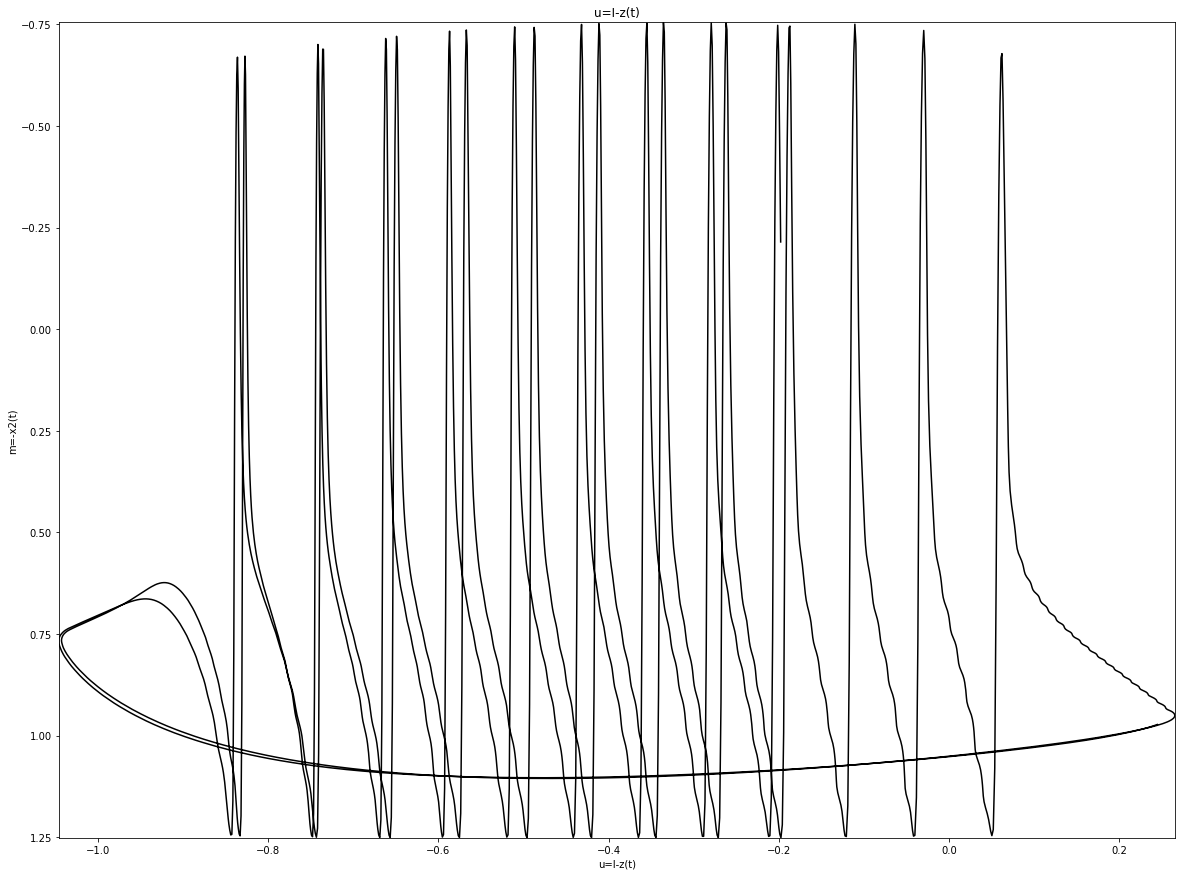

done


<Figure size 432x288 with 0 Axes>

In [29]:
data_dict = { 
             'u=I-z(t)': 3.1-z[:,46,np.newaxis],
            'm=-x2(t)': -x2[:,46,np.newaxis],
}
plotter = PlotterSim(config)
special_idx = []
plot, axes, lines = plotter.plot_timeseries(data_dict, [], mode="traj", special_idx=special_idx, 
                                        title='Z vs X2 space trajectory', figure_name="Z vs X2 Space Trajectory",
                                        labels=reg_labels)


print("done")

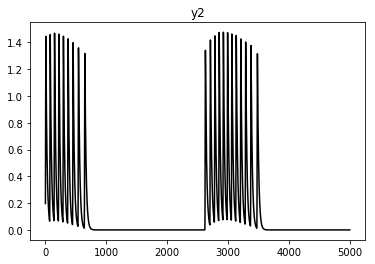

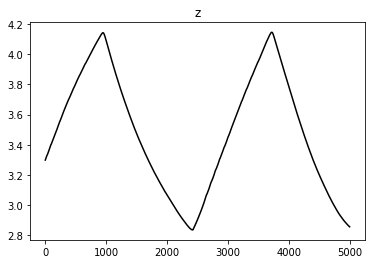

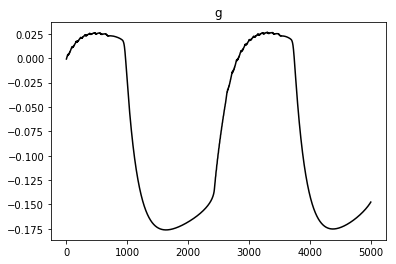

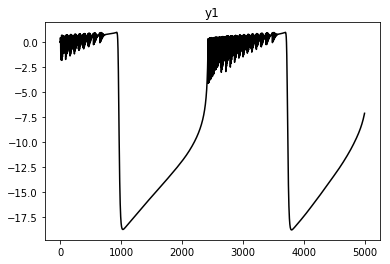

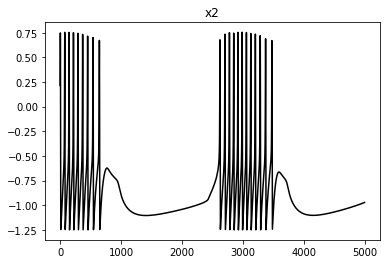

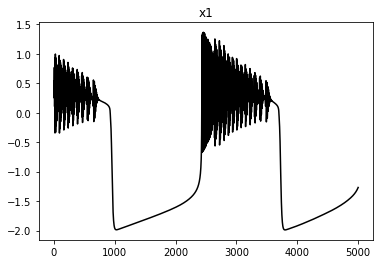

In [30]:
toplot = {
    'z': z,
    'x1': x1,
    'x2': x2,
    'y1': y1,
    'y2': y2,
    'g': g
}

for key, var in toplot.iteritems():
    plt.figure()
    plt.plot(var.T[46,:], 'k')
    axes = plt.gca()
    plt.title(key)
    
# plt.plot(test1, test2, 'k*')
# axes = plt.gca()
# axes.invert_yaxis()
# plt.title('Second Region EZ Set')
# plt.xlabel('u')
# plt.ylabel('m')

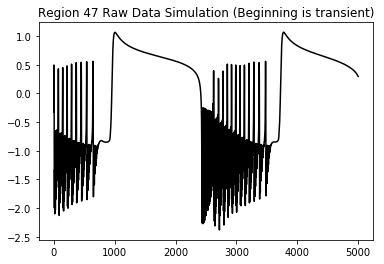

(5000, 84)


In [33]:

plt.plot(epits.T[46,:], 'k')
plt.title("Region 47 Raw Data Simulation (Beginning is transient)")
plt.show()
print(epits.shape)

# Plotting the Other EZ Region

- Here, you'll notice that the time period from ~10000 - ~17000, the region 47 is not in the limit cycle. We plot the phase space during that time period.
- Afterwards, you see that the system for that node oscillates around the green line, or the Supercritical Hopf bifurcation regime (at least of Marisa's plot of the Epileptor Bifurcation m vs u)

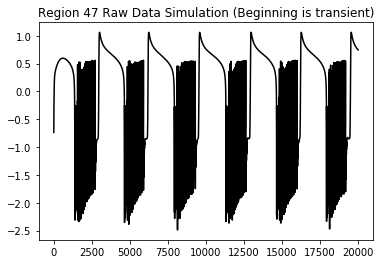

(84, 20000)


In [12]:
plt.plot(epits[47,:], 'k')
plt.title("Region 47 Raw Data Simulation (Beginning is transient)")
plt.show()
print(epits.shape)

Text(0,0.5,'m')

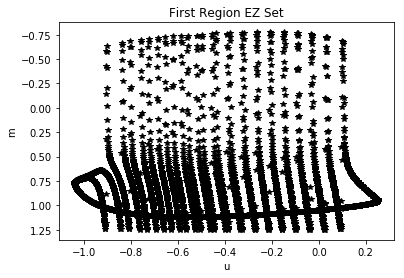

In [13]:
test1 = 3.1-z[10000:17000,47]
test2 = -x2[10000:17000,47]

plt.plot(test1, test2, 'k*')
axes = plt.gca()
axes.invert_yaxis()
plt.title('First Region EZ Set')
plt.xlabel('u')
plt.ylabel('m')